<a href="https://colab.research.google.com/github/nelsonalbertohj/Magno-Parvo-CNN/blob/main/Data_analysis_and_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Analysis and Results

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef
import seaborn as sn
import matplotlib.colors as colors
from scipy.stats import binom

print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Loading Testing Sets and Models

In [ ]:
root = "/content/drive/MyDrive/Undergrad Docs/Senior/9.60/Vision Project/Vision Dataset"
N_CLASSES = 10
loc = root + f"/Imagenet-{N_CLASSES}-1500-splits/test"
data_dir = pathlib.Path(loc)

batch_size = 32
img_height = 224
img_width = 224

#Testing set
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1297 files belonging to 10 classes.


In [ ]:
def img_transforms(data,label): #The vanilla testing set
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

def blurr_img_transforms(data,label): #The blurred testing set
    data = tfa.image.gaussian_filter2d(data,filter_shape=(10,10),sigma=5.0)
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE
test_ds_vanilla = test_ds.map(img_transforms)
test_ds_blurred = test_ds.map(blurr_img_transforms)

CASHE_Test_vanilla = root + f"/Imagenet-{N_CLASSES}-1500-splits/CASHE_Test_{N_CLASSES}_1500"
test_ds_vanilla = test_ds_vanilla.cache(CASHE_Test_vanilla).prefetch(buffer_size=AUTOTUNE)

CASHE_Test_blurred = root + f"/Imagenet-{N_CLASSES}-1500-splits/CASHE_Test_Dist_Blur_{N_CLASSES}_1500"
test_ds_blurred = test_ds_blurred.cache(CASHE_Test_blurred).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Used to create CASHE in local disk by loading all images
idx = 0
start_time = time.time()
for t in test_ds_vanilla:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

time to get object:  0.08382320404052734
time to get object:  0.053678274154663086
time to get object:  0.05150198936462402
time to get object:  0.04128289222717285
time to get object:  0.03199410438537598
time to get object:  0.0369105339050293
time to get object:  0.032631635665893555
time to get object:  0.03940272331237793
time to get object:  0.030530929565429688
time to get object:  0.03053116798400879
time to get object:  0.03687262535095215
time to get object:  0.040352821350097656
time to get object:  0.0351407527923584
time to get object:  0.031316518783569336
time to get object:  0.038193702697753906
time to get object:  0.031080245971679688
time to get object:  0.03023076057434082
time to get object:  0.029727458953857422
time to get object:  0.05355238914489746
time to get object:  0.04650092124938965
time to get object:  0.04427218437194824
time to get object:  0.04439377784729004
time to get object:  0.04396390914916992
time to get object:  0.0494694709777832
time to get

In [ ]:
dual_stream_model = tf.keras.models.load_model(root + f"/Models/Early_Testing_Models/FullRes_with_CNN_1000_Samples_{N_CLASSES}Classes")
single_model = tf.keras.models.load_model(root + f"/Models/Early_Testing_Models/Dualstream_with_CNN_1000_Samples_{N_CLASSES}Classes")

### Testing the Vanilla Testing Set

In [ ]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_vanilla)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_vanilla)

41/41 [==============================] - 4s 70ms/step - loss: 1.1932 - accuracy: 0.7733


In [ ]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_vanilla)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_vanilla)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_vanilla])
true_outputs = np.argmax(true_outputs,axis=1)

In [ ]:
print(classification_report(true_outputs,dual_pred_outputs))
print(matthews_corrcoef(true_outputs, dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       140
           1       0.97      0.91      0.93       127
           2       0.63      0.79      0.70       135
           3       0.71      0.82      0.76       125
           4       0.75      0.70      0.73       125
           5       0.67      0.78      0.72       128
           6       0.77      0.84      0.80       139
           7       0.78      0.57      0.66       127
           8       0.79      0.94      0.86       127
           9       0.82      0.60      0.69       124

    accuracy                           0.77      1297
   macro avg       0.78      0.77      0.77      1297
weighted avg       0.78      0.77      0.77      1297

0.7460387968527745


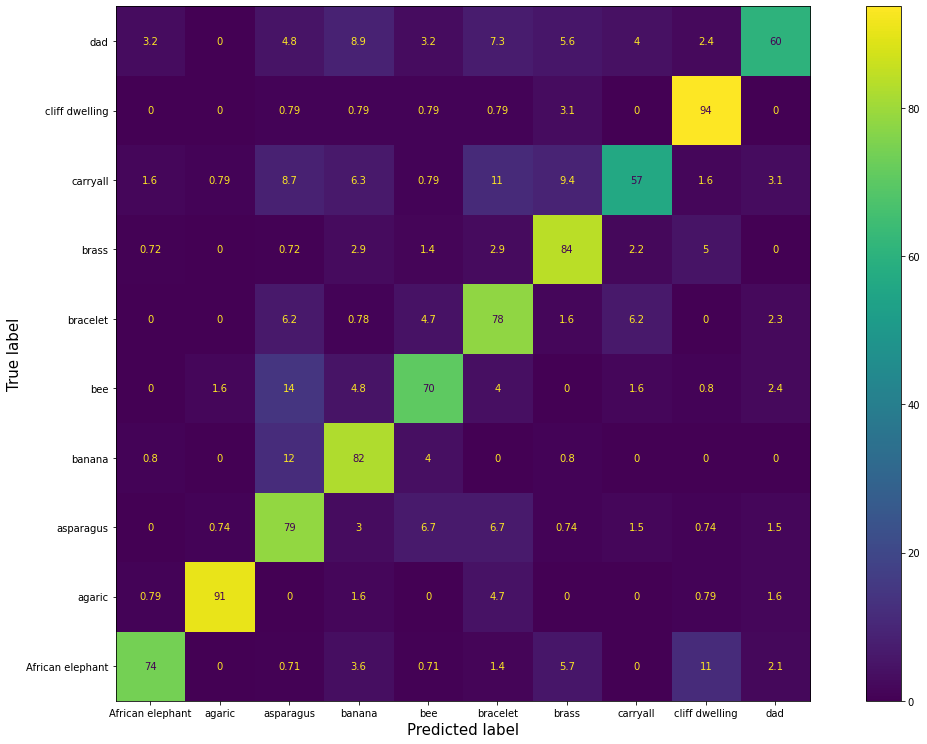

In [ ]:
#Generate Confusion Matrix for Dual-stream model
A = confusion_matrix(true_outputs,dual_pred_outputs)
cm_dual_vanilla = confusion_matrix(true_outputs,dual_pred_outputs,normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_dual_vanilla,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

In [ ]:
print(classification_report(true_outputs,single_pred_outputs))
print(matthews_corrcoef(true_outputs, single_pred_outputs))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       140
           1       0.94      0.86      0.90       127
           2       0.75      0.82      0.78       135
           3       0.68      0.85      0.76       125
           4       0.67      0.82      0.74       125
           5       0.75      0.69      0.72       128
           6       0.89      0.81      0.85       139
           7       0.83      0.55      0.66       127
           8       0.85      0.79      0.82       127
           9       0.67      0.73      0.70       124

    accuracy                           0.77      1297
   macro avg       0.78      0.77      0.77      1297
weighted avg       0.78      0.77      0.77      1297

0.7491826868726083


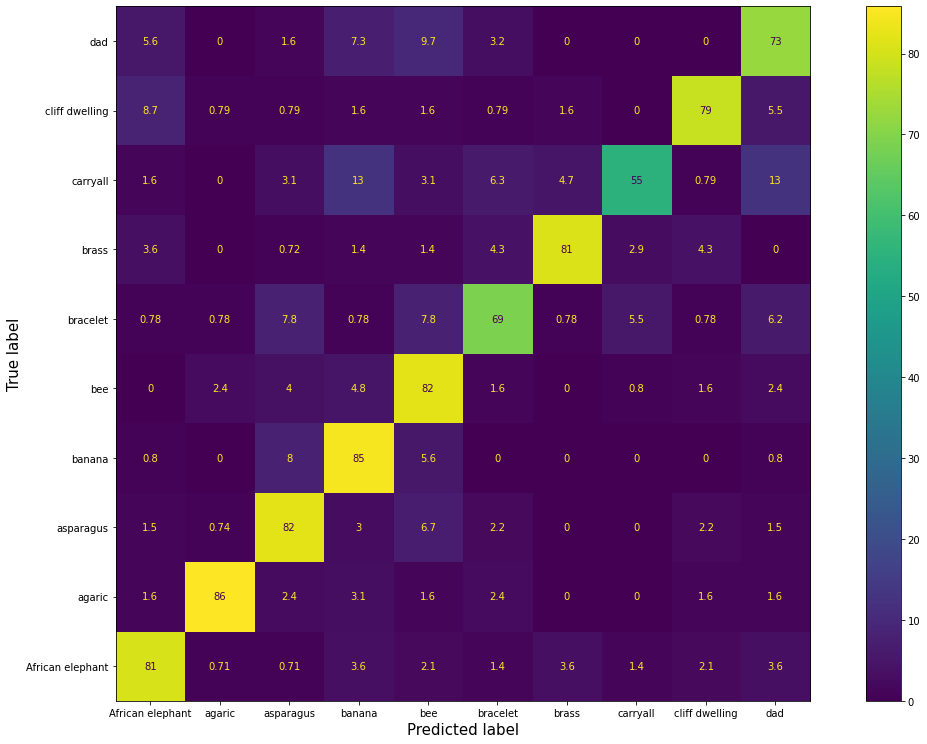

In [ ]:
#Generate Confusion Matrix for Single-stream ResNet
cm_single_vanilla = confusion_matrix(true_outputs,single_pred_outputs, normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_single_vanilla,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

'\ndisp_cm = ConfusionMatrixDisplay(cm_diff_vanilla,display_labels=class_names)\n\nax.set_xlabel("Predicted Label", fontsize = 15)\nax.set_ylabel("True Label", fontsize = 15)\n\nplt.tight_layout()\n\ndisp_cm.plot(ax=ax)\ndisp_cm.ax_.invert_yaxis()\n\nim = disp_cm.im_\n\n#plt.set_cmap(\'bwr\')'

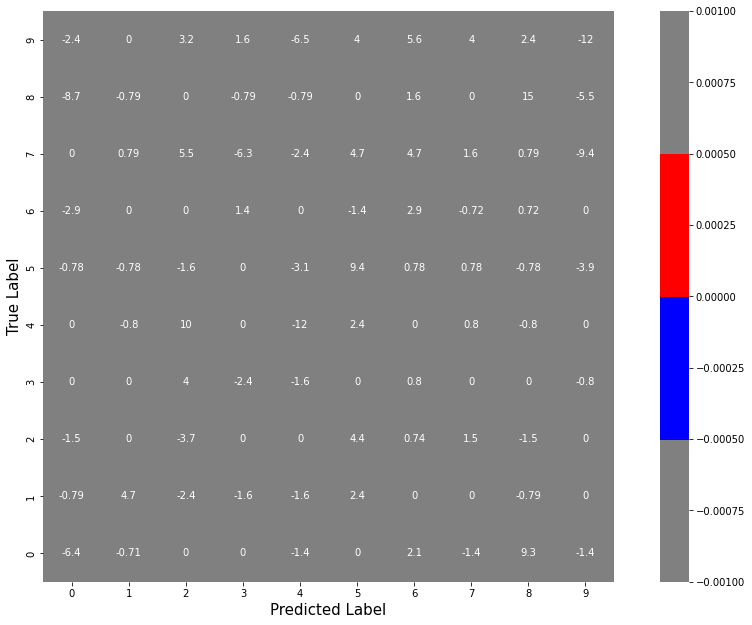

In [ ]:
# Confusion Difference Matrix (Dual minus Single)

# Test if Single (B) is draw from a differnt distrbution that Dual (A)

cm_diff_vanilla = cm_dual_vanilla - cm_single_vanilla

B = confusion_matrix(true_outputs,single_pred_outputs)
n_trials = np.sum(B, axis=1)
p = confusion_matrix(true_outputs,single_pred_outputs, normalize='true')
m = np.copy(B)
C = np.zeros(shape=(10,10))
for row in range(10):
    n = n_trials[row]
    for col in range(10):
        dist = binom(n,p[row, col])
        if cm_diff_vanilla[row,col] >= 0:
            sign = 1
        else:
            sign = -1
        C[row,col] = dist.pmf(B[row,col]) * sign

cmap = colors.ListedColormap(["gray", "blue", "red", "gray"])
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-3, vmin=-1e-3, square=True, annot=cm_diff_vanilla, cmap=cmap)
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=cm_diff_vanilla, cmap='bwr')
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=cm_diff_vanilla, cmap=cmap)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
ax.invert_yaxis()



'''
disp_cm = ConfusionMatrixDisplay(cm_diff_vanilla,display_labels=class_names)

ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
disp_cm.ax_.invert_yaxis()

im = disp_cm.im_

#plt.set_cmap('bwr')'''

### Testing the Blurred condition

In [ ]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_blurred)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_blurred)

41/41 [==============================] - 2s 44ms/step - loss: 2.5524 - accuracy: 0.5436


In [ ]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_blurred)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_blurred)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_blurred])
true_outputs = np.argmax(true_outputs,axis=1)

In [ ]:
print(classification_report(true_outputs,dual_pred_outputs))
print(matthews_corrcoef(true_outputs, dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.87      0.44      0.58       140
           1       0.97      0.77      0.86       127
           2       0.39      0.88      0.54       135
           3       0.66      0.60      0.63       125
           4       0.63      0.70      0.66       125
           5       0.51      0.70      0.59       128
           6       0.88      0.68      0.76       139
           7       0.85      0.31      0.46       127
           8       0.79      0.72      0.75       127
           9       0.59      0.60      0.60       124

    accuracy                           0.64      1297
   macro avg       0.71      0.64      0.64      1297
weighted avg       0.72      0.64      0.64      1297

0.6077948055109794


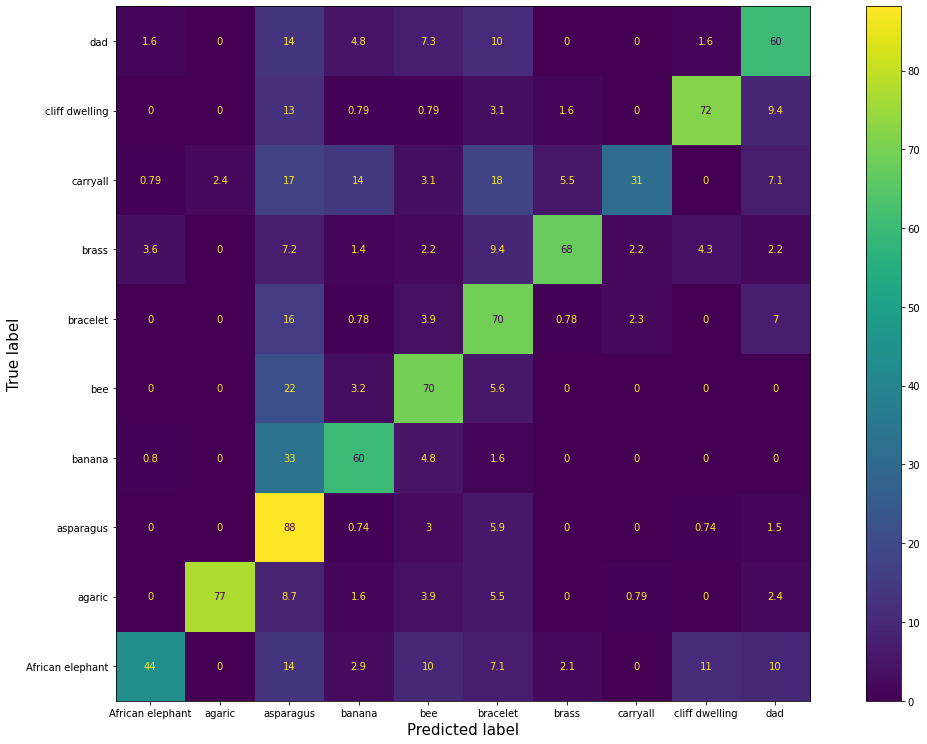

In [ ]:
#Generate Confusion Matrix for Dual-stream model

cm_dual_blur = confusion_matrix(true_outputs,dual_pred_outputs,normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_dual_blur,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

In [ ]:
print(classification_report(true_outputs,single_pred_outputs))
print(matthews_corrcoef(true_outputs, single_pred_outputs))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       140
           1       0.96      0.71      0.81       127
           2       0.39      0.84      0.53       135
           3       0.45      0.38      0.41       125
           4       0.46      0.71      0.56       125
           5       0.56      0.50      0.53       128
           6       0.88      0.38      0.53       139
           7       0.61      0.38      0.47       127
           8       0.65      0.33      0.44       127
           9       0.46      0.63      0.53       124

    accuracy                           0.54      1297
   macro avg       0.61      0.54      0.54      1297
weighted avg       0.61      0.54      0.54      1297

0.5005604646541421


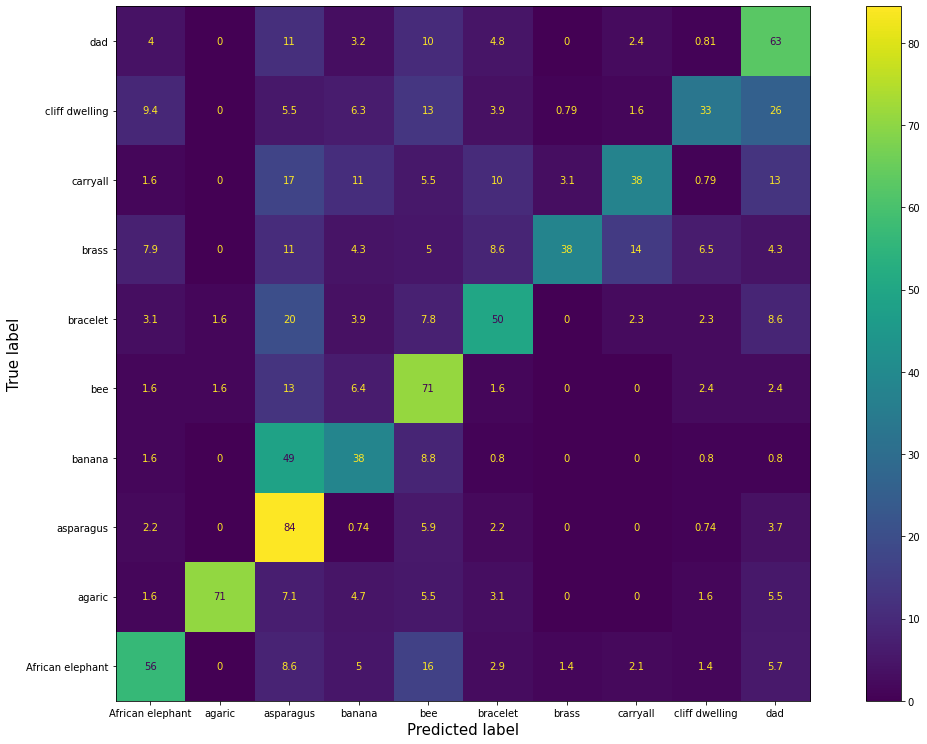

In [ ]:
#Generate Confusion Matrix for Single-stream ResNet

cm_single_blur = confusion_matrix(true_outputs,single_pred_outputs,normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_single_blur,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

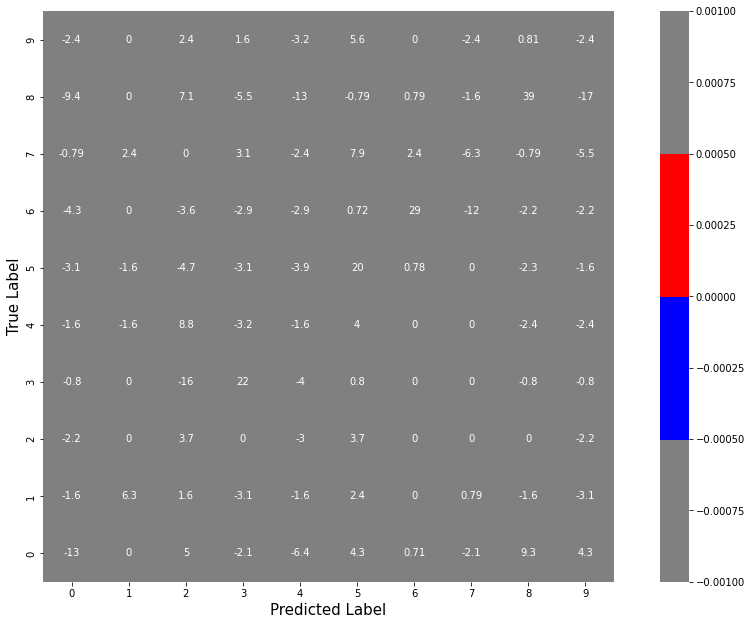

In [ ]:
cm_diff_blur = cm_dual_blur - cm_single_blur

B = confusion_matrix(true_outputs,single_pred_outputs)
n_trials = np.sum(B, axis=1)
p = confusion_matrix(true_outputs,single_pred_outputs, normalize='true')
m = np.copy(B)
C = np.zeros(shape=(10,10))
for row in range(10):
    n = n_trials[row]
    for col in range(10):
        dist = binom(n,p[row, col])
        if cm_diff_blur[row,col] >= 0:
            sign = 1
        else:
            sign = -1
        C[row,col] = dist.pmf(B[row,col]) * sign

cmap = colors.ListedColormap(["gray", "blue", "red", "gray"])
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-3, vmin=-1e-3, square=True, annot=cm_diff_blur, cmap=cmap)
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=C, cmap='bwr')
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=cm_diff_blur, cmap=cmap)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
ax.invert_yaxis()


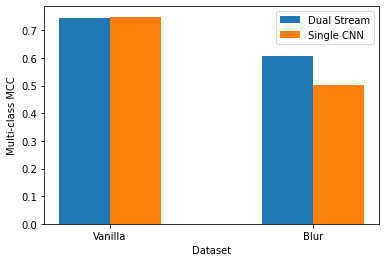

In [ ]:
MCCs = np.array([[0.7460387968527745, 0.7491826868726083],
                [0.6077948055109794, 0.5005604646541421]])

fig, ax = plt.subplots()
x = np.arange(2)
ax.bar(x-.125, MCCs[:,0], width=.25, label='Dual Stream')
ax.bar(x+.125, MCCs[:,1], width=.25, label='Single CNN')
ax.set_xticks((0,1))
ax.set_xticklabels(('Vanilla', 'Blur'))
ax.set_xlabel('Dataset')
ax.set_ylabel('Multi-class MCC')
plt.legend()
